In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


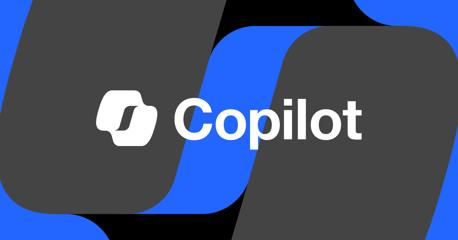

[Microsoft enables enterprises to create agents with Copilot.](https://www.theverge.com/2024/5/21/24158030/microsoft-copilot-ai-automation-agents) - The Verge

___

[WSJ on vector databases. Not sure you need a whole new database engine to do fast nearest neighbors but here we are.](https://www.wsj.com/articles/how-a-decades-old-technology-and-a-paper-from-meta-created-an-ai-industry-standard-354a810e?st=g92jj70ev26pep4&reflink=desktopwebshare_permalink)

___

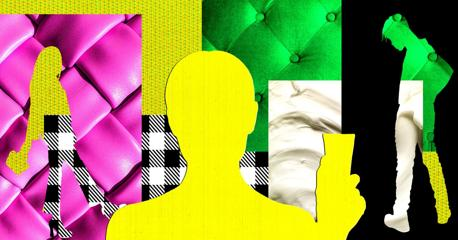

[Gen-AI ads will show how clothes fit your body and skin tone.](https://www.wired.com/story/google-ai-shopping-clothes-fit-different-bodies/) - WIRED

___

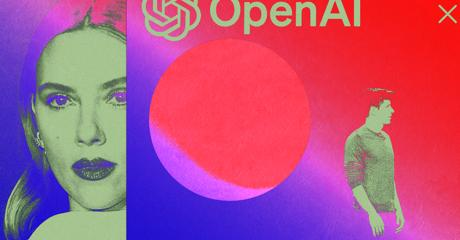

[The 'I made this' and data rape ethos now encompasses every bit of you and every bit of content you make and anyone ever made. Consent be damned.](https://www.theatlantic.com/technology/archive/2024/05/openai-scarlett-johansson-sky/678446/?gift=2iIN4YrefPjuvZ5d2Kh306LFFT6yU6HZVP_tmIcOfig&utm_source=copy-link&utm_medium=social&utm_campaign=share) - The Atlantic

___

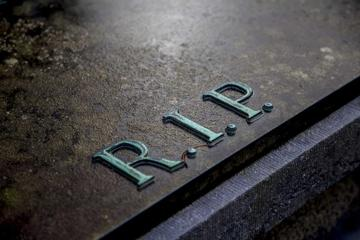

[What happens when gen AI kills all the reliable sources?](https://www.computerworld.com/article/2114681/what-happens-when-genai-vendors-kill-off-their-best-sources.html) - Computerworld

___

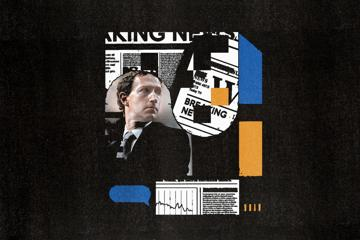

[Meta's chat bot scrapes news sites and summarizes them, will cite sources on demand.](https://www.washingtonpost.com/technology/2024/05/22/meta-ai-news-summaries/) - Washington Post

___

[Satya Nadella says we shouldn't anthropomorphize AIs. For one thing, they hate it when we do that. ChatGPT leaning into freighting their chatbot fake emotions feels manipulative, selling it as something it's not, dangerous for users in a way that's hard to red-team, risks a backlash.](https://www.bloomberg.com/news/articles/2024-05-21/microsoft-s-satya-nadella-wants-us-to-stop-treating-ai-like-humans)

___

[Microsoft CTO says AI capabilities will keep on growing exponentially, haven't reached the sigmoid flattening yet](https://www.reddit.com/r/ChatGPT/comments/1cxr1df/microsoft_cto_says_ai_capabilities_will_continue/)

___

[The Stig comfortably beats an autonomous racecar on the track](https://www.topgear.com/car-news/video/stig-vs-artificial-intelligence-who-wins)

___

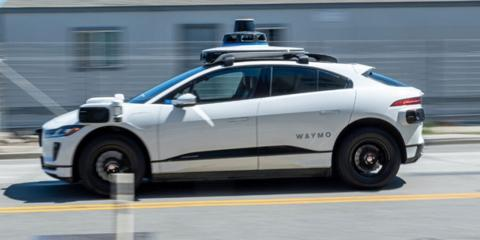

[When a Waymo gets confused, it sends an SOS to a remote driver.](https://arstechnica.com/cars/2024/05/on-self-driving-waymo-is-playing-chess-while-tesla-plays-checkers/) - Ars Technica

___

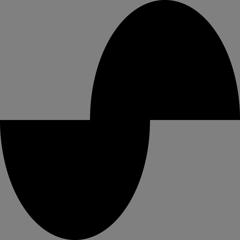

[Suno raises \\$125m at \\$500m valuation](https://suno.com/song/5101c22d-e123-477b-8607-e09b61292ec6)

___

[Cloud AI price wars in China -](https://www.theregister.com/2024/05/22/china_ai_cost_crash/)

___

[China now has ChatXiPT with Xi Jinping thought on socialism with Chinese characteristics. Hope it doesn't hallucinate and stray from the party line.](https://www.ft.com/content/43378c6e-664b-4885-a255-31325d632ee9)

___

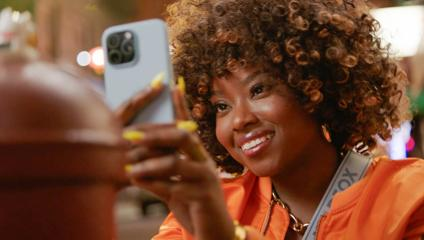

[Adobe brings Firefly AI to Lightroom.](https://fstoppers.com/photoshop/adobe-brings-firefly-generative-ai-technology-lightroom-668084) - Fstoppers

___

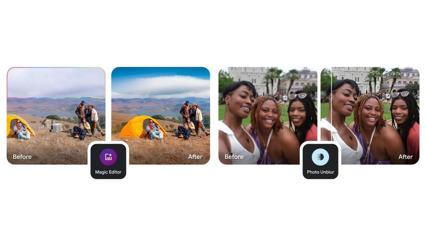

[Google Photos rolls out Magic Editor to smartphone users.](https://www.phonearena.com/news/google-photos-opens-up-magic-editor-and-other-ai-image-editing-tools-to-everyone_id158540) - PhoneArena

___

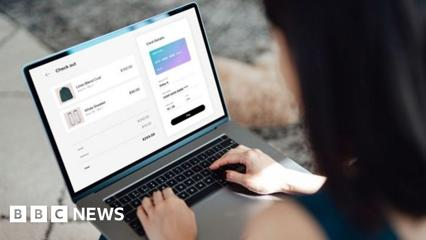

[Is Copilot+Recall a privacy nightmare? What is your more-human-than-human hybrid AI-cloud PC doing with the pictures and data it collects on you?](https://www.bbc.com/news/articles/cpwwqp6nx14o)

___

[Microsoft is up to 135 Copilots and counting.](https://www.theregister.com/2024/05/21/microsoft_extends_reach_of_copilot/?td=keepreading)

___

[Is your AI-first, cloud-centric, closed ecosystem PC platform taking you hostage?](https://venturebeat.com/ai/ceding-control-how-copilot-and-pcs-could-make-enterprises-beholden-to-microsoft/)

___

[Humane seeks buyer after raising \\$200m, getting torn to shreds by reviewers.](https://www.bloomberg.com/news/articles/2024-05-22/wearable-ai-startup-humane-is-said-to-explore-potential-sale)

___

Elon, have you seen this cool new slowpoke meme?

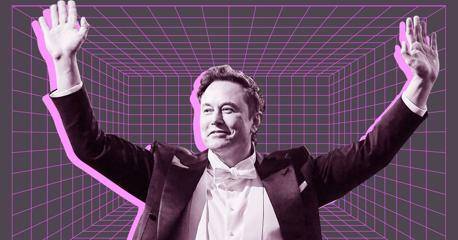

[Grok working on multimodality. Will be trained on audio, video and (non-woke) brainwaves.](https://www.theverge.com/2024/5/21/24161764/elon-musk-xai-grok-multimodal-ai) - The Verge

___

[Open source in the cloud / AI era is losing its meaning. Kind of need a rating system.](https://www.nytimes.com/2024/05/17/business/what-is-openwashing-ai.html)

___

[Anthropic work sheds light on how LLMs think and store knowledge, could improve interpretability and also ability to train and add new knowledge easily.](https://www.nytimes.com/2024/05/21/technology/ai-language-models-anthropic.html)

___

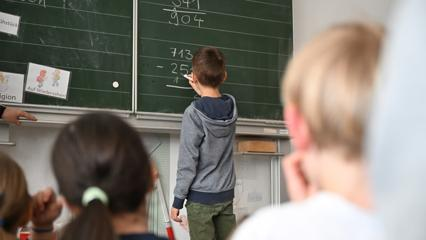

[Khanmigo now free to teachers in US as Microsoft offers hosting.](https://www.cnbc.com/2024/05/21/microsoft-khan-academy-launch-free-ai-assistant-for-all-us-teachers.html) - CNBC

___

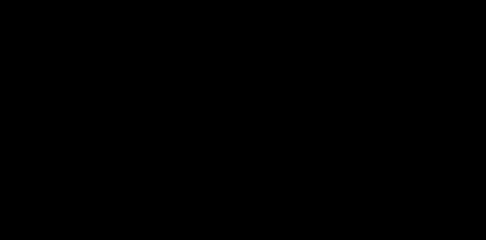

[If only there were some AI assistant that could have told Sam Altman what he was doing was not a good idea](https://far.ai/post/2024-03-llm-moral-survey/) - FAR AI

___

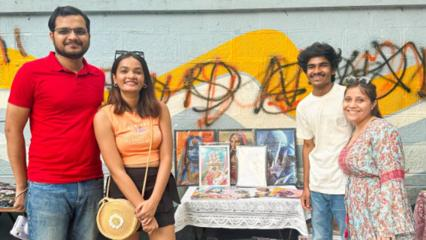

[Man sells AI art on the street, gets backlash. 

Who needs a caricature artist using pastels in Times Square or Central Park? The guy could have his smart glasses take some snapshots, send them to Midjourney with a prompt, touch them up on his tablet LOL.](https://www.news18.com/viral/all-of-this-is-ai-art-bengaluru-man-faces-backlash-for-selling-paintings-on-street-8897229.html) - News18

___

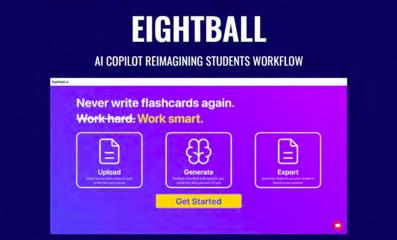

[Emory students won a prize for an AI tool, then got suspended because it could be used for cheating.](https://www.404media.co/university-suspends-students-for-ai-homework-tool-it-paid-them-10-000-to-make/) - 404 Media

___

[The voice mode OpenAI demonstrated will supposedly be available in 'coming months' now - www.reddit.com/r/ChatGPT/co... Vaporware to blunt Google's Astra demo, which also won't be working like that anytime soon. Video understanding is not that good, will cost \\$5 an hour, plus privacy issues.](https://www.reddit.com/r/ChatGPT/comments/1cwoxrd/a_few_hours_ago_they_added_an_faq_post_saying/)

___

The Minecraft demo is super interesting if you apply it to say, answer questions and generating dataviz in PowerBI based on your CRM data, but sending this stuff to the cloud may be problematic.

[Nvidia's moat is Cuda, rival chip vendors and buyers are investing heavily in alternatives like Triton and UXL.](https://www.ft.com/content/320f35de-9a6c-4dbf-b42f-9cdaf35e45bb)

___

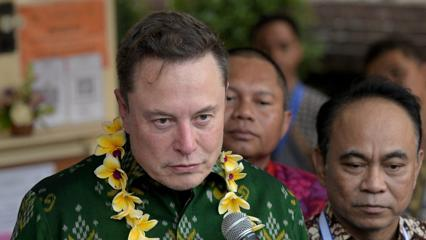

[Jalopnik: Tesla investors must choose between giving Musk \\$55 billion, or letting him take away part of the business, which he already said will work fine without him.](https://jalopnik.com/elon-musk-who-claimed-tesla-will-solve-autonomy-with-o-1851489401) - Jalopnik

___

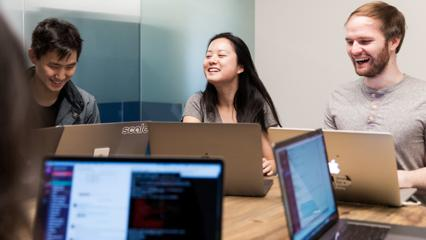

[Scale AI, which runs armies of offshore workers doing data labeling, raises another \\$1b at a \\$14b valuation. Feels a bit bubbly, seems like a low-margin, self-financing business, not the kind of thing that needs force-feeding or growth financing in some kind of land grab dynamic.](https://www.cnbc.com/2024/05/21/amazon-meta-back-scale-ai-in-1-billion-funding-deal.html) - CNBC

___

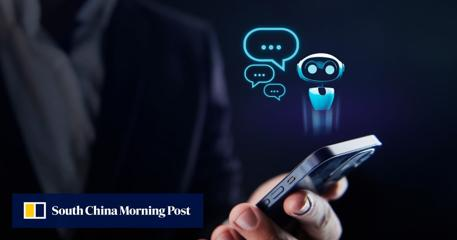

[China's Moonshot AI model company raised \\$1b in February, looking for more money at a slightly higher valuation.](https://www.scmp.com/tech/tech-trends/article/3263507/hot-chinese-ai-start-moonshot-talks-new-funding-boosting-valuation-us3-billion) - South China Morning Post

___

[French startup 'H' raises \\$220m for 'holistic AI'. Thats…quite an initial round, presumably showed more than a nice PowerPoint.](https://www.bloomberg.com/news/articles/2024-05-21/french-startup-h-raises-220-million-from-accel-uipath-bernard-arnault-amazon)

___

[China chatbot war heats up.](https://www.bloomberg.com/news/articles/2024-05-21/alibaba-sparks-china-ai-price-war-with-spate-of-steep-discounts)

___

[LLMs equal humans on detecting mental states, moods, and hidden meetings.](https://techxplore.com/news/2024-05-llms-equal-outperform-humans-theory.html)

___

[Comparing Scarlett Johansson, her performance as Samantha in 'Her', and OpenAI's Sky](https://www.reddit.com/r/ChatGPT/comments/1cwy6wz/vocal_comparison_scarjo_vs_samantha_vs_sky/)

___

[Why the Mac ChatGPT app is cool.](https://www.pocket-lint.com/chatgpt-mac-app/)

___

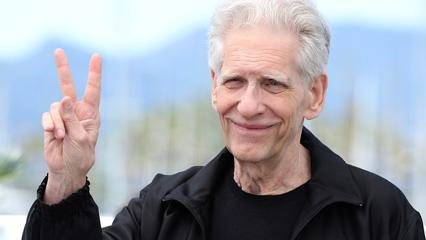

[David Cronenberg's creepy AI movie.](https://variety.com/2024/film/festivals/david-cronenberg-ai-filmmaking-promise-threat-the-shrouds-1236011528/) - Variety

___

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


[Co-Writing Screenplays and Theatre Scripts with Language Models An Evaluation by Industry Professionals arxiv.org/pdf/2209.14958](https://arxiv.org/pdf/2209.14958)

___

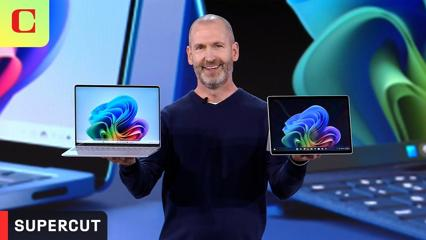

[Microsoft's event in 13 minutes.](https://www.youtube.com/watch?v=iHQgf3DNAr8) - YouTube

___

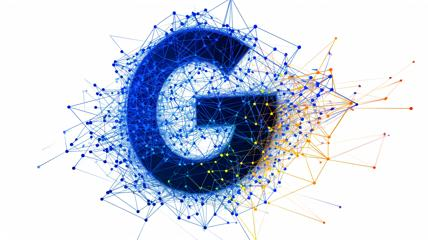

[Googler leaves with parting shot saying the AI strategy is Google+ all over. I'm not persuaded, Google's mission is making the world's information accessible, LLMs that have semantic understanding are likely to be a big part of it. Fine line between panic and missing the boat.](https://the-decoder.com/ex-googler-says-companys-ai-panic-is-like-google-fiasco-all-over-again/) - THE DECODER

___

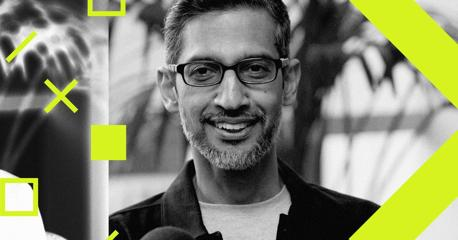

[Sundar Pichai says he is not killing the Web.](https://www.theverge.com/24158374/google-ceo-sundar-pichai-ai-search-gemini-future-of-the-internet-web-openai-decoder-interview) - The Verge

___

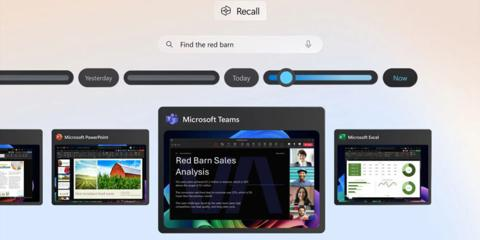

[This recall feature will trigger some backlash. Presumably people will be able opt out. I'm a little suspicious about the possibility of AI in the cloud accessing those images.](https://arstechnica.com/gadgets/2024/05/microsofts-new-recall-feature-will-record-everything-you-do-on-your-pc/) - Ars Technica

___

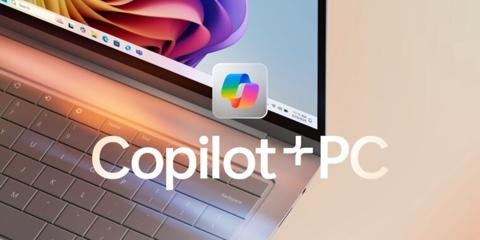

[The Intel and AMD PCs are still lagging in AI compute, at least without Nvidia GPUs, and ARM is pretty unproven on Windows and seems likely to be a trouble spot.](https://arstechnica.com/gadgets/2024/05/microsofts-copilot-ai-pc-requirements-are-embarrassing-for-intel-and-amd/) - Ars Technica

___

[Satya Nadella says new Windows PCs will give Apple a run for its money, ARM will actually work this time, and we got all this AI stuff.](https://www.wsj.com/tech/personal-tech/microsoft-ceo-satya-nadella-interview-ai-laptops-76eef1e1)

___

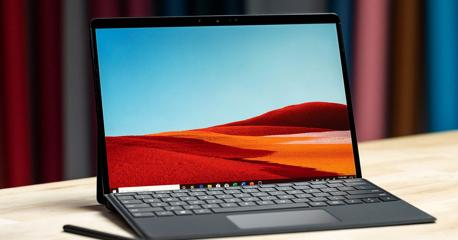

[Microsoft announced some AI PCs and ARM stuff. Is this something? 🤷](https://www.theverge.com/2024/5/20/24158827/microsoft-surface-windows-ai-event-live-blog-news-updates) - The Verge

___

[ScarJo speaks!!](https://x.com/BobbyAllyn/status/1792679435701014908) - X (formerly Twitter)

___

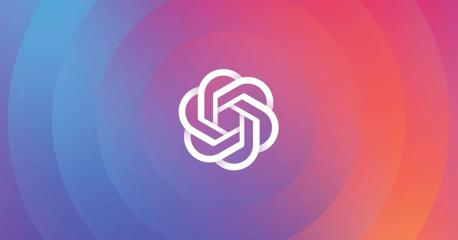

[OpenAI is ‘in conversations’ with Scarlett Johansson over the ChatGPT voice that sounds just like her. Coquettish, flirty conversations. Not taping them for future training purposes at all, why would you think that?](https://www.theverge.com/2024/5/20/24161108/openai-scarlett-johanson-chatgpt-her-sky) - The Verge

___

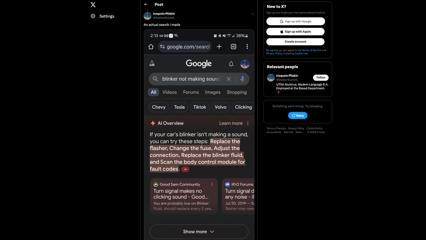

[Google's AI overview recommends changing your blinker fluid.](https://jalopnik.com/googles-new-ai-overview-says-you-might-need-to-change-y-1851488127) - Jalopnik

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 5, 22, 14, 22, 23, 864000)

In [12]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-05-21 04:24:07.451677
